## Reimplementation of Median filter tuned via self-supervised loss

See [Noise2self paper](https://arxiv.org/pdf/1901.11365.pdf) or [original repo](https://github.com/czbiohub/noise2self) for more details.

This notebook will take a noisy image, and use it to tune the radius of a median filter. We will use two median filters: a classic circular median filter and a donut filter that is $\mathcal{J}$-invariant. We will compare the self-supervised and ground truth losses for the filters over a range of radii and show that the minimum of the self-supervised loss of the $\mathcal{J}$-invariant donut filter is the same as the minimum of the supervised loss.

For this implementaiton, we rely heavily on the built in functionalities of the `scikit-image` library.

In [25]:
# import relevant libraries
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

from skimage import img_as_float, data
from skimage.filters import median
from skimage.morphology import disk
from skimage.measure import compare_mse as mse
from skimage.util import random_noise
from skimage.color import rgb2gray

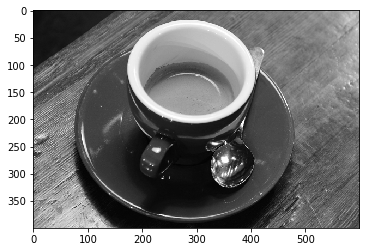

In [3]:
img = rgb2gray(data.coffee())
plt.imshow(img, interpolation='nearest', cmap='gray')
plt.show()

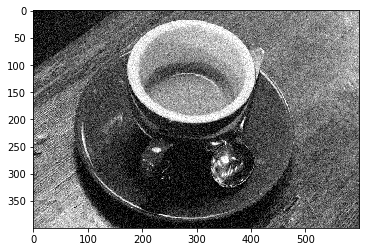

In [4]:
# add some noise to the image
noisy_img = random_noise(img, mode='gaussian', seed=3, var=0.01)
plt.imshow(noisy_img, interpolation='nearest', cmap='gray')
plt.show()

In [5]:
# define a function to convert a disk into a donut using a mask
def mask(x):
    x[len(x)//2, len(x)//2] = 0
    return x

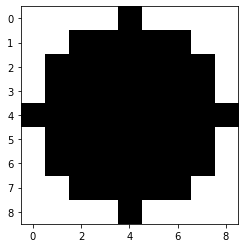

In [6]:
# plot disk and donut filters (black squares are 1's and white squares are 0's)
plt.imshow(1 - disk(4), cmap='gray')

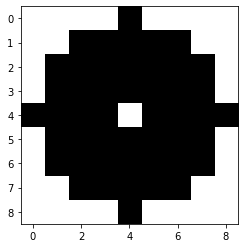

In [7]:
plt.imshow(1 - mask(disk(4)), cmap='gray')

In [18]:
# apply the filters to the noisy image
radii = range(1,8)
img_med_fil = [median(noisy_img, disk(i)) for i in radii]
img_med_mask_fil = [median(noisy_img, mask(disk(i))) for i in radii]

In [22]:
# function for calculating loss
def calculate_error(original, noisy, img_list):
    self_supervised_mse = [mse(noisy, img) for img in img_list]
    gt_mse = [mse(original, img) for img in img_list]
    
    return self_supervised_mse, gt_mse

In [23]:
# calculate the mse of the self-supervised loss and the ground truth loss
disk_mse, disk_mse_gt = calculate_error(img, noisy_img, img_med_fil)
donut_mse, donut_mse_gt = calculate_error(img, noisy_img, img_med_mask_fil)

/home/clin/.virtualenvs/env_n2s/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: DEPRECATED: skimage.measure.compare_mse has been moved to skimage.metrics.mean_squared_error. It will be removed from skimage.measure in version 0.18.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/clin/.virtualenvs/env_n2s/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: DEPRECATED: skimage.measure.compare_mse has been moved to skimage.metrics.mean_squared_error. It will be removed from skimage.measure in version 0.18.
  after removing the cwd from sys.path.


In [26]:
print('The best filter radius occurs at radius = %d' % radii[np.argmin(donut_mse)])

The best filter radius occurs at radius = 3


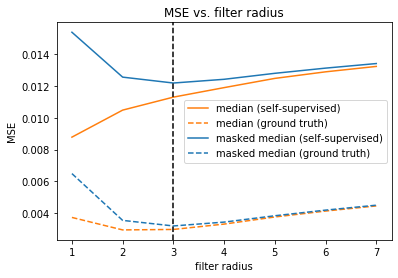

In [35]:
plt.plot(radii, disk_mse, label='median (self-supervised)', color='C1')
plt.plot(radii, disk_mse_gt, label='median (ground truth)', color='C1', linestyle='--')
plt.plot(radii, donut_mse, label='masked median (self-supervised)', color='C0')
plt.plot(radii, donut_mse_gt, label='masked median (ground truth)', color='C0', linestyle='--')

plt.axvline(radii[np.argmin(donut_mse)], linestyle='--', color='k')

plt.title('MSE vs. filter radius')
plt.xlabel('filter radius')
plt.ylabel('MSE')

plt.legend()
plt.savefig('median_filter_results.png')

As seen above, the minimum of the self-supervised loss for the $\mathcal{J}$-invariant donut filter occurs at the minimum of its supervised loss. This is not the same case for the self-supervised loss of the classic median filter because it is not $\mathcal{J}$-invariant.